In [1]:
import sys
sys.path.append('../')
import networkx as nx
import matplotlib.pyplot as plt
from networkx.drawing.nx_agraph import graphviz_layout
from smodels.theory.element import Element
from smodels.particlesLoader import BSMList
from smodels.share.models.SMparticles import SMList
from smodels.theory.model import Model
from smodels.theory.decomposer import getDecayTrees, addOneStepDecays,cascadeDecay
from smodels.theory.tree import Tree, ParticleNode
from smodels.tools.physicsUnits import fb, GeV
import itertools

#### Compute number of possible decays:

In [2]:
def getNdecays(pdg):
    ptc = model.getParticlesWith(pdg=pdg)
    nDecays = 0
    if not ptc:
        return 0
    ptc = ptc[0]
    if not hasattr(ptc,'decays'):
        return 1
    if not ptc.decays:
        return 1
    if ptc.isStable():
        return 1
    
    for dec in ptc.decays:
        daughterPDG = [abs(pid) for pid in dec.ids if abs(pid) > 10000][0]
        nDecays += getNdecays(daughterPDG)
    
    return nDecays


### Load model

In [3]:
slhafile = '../inputFiles/slha/lightEWinos.slha'
model = Model(BSMparticles=BSMList, SMparticles=SMList)
model.updateParticles(inputFile=slhafile)


### Create node with primary particle

In [4]:
pv = ParticleNode(model.getParticlesWith(label='PV')[0],0)
pv.nodeWeight = 1.0*fb
n1 = ParticleNode(model.getParticlesWith(pdg=1000022)[0],1)
n2 = ParticleNode(model.getParticlesWith(pdg=1000023)[0],3)
c2 = ParticleNode(model.getParticlesWith(pdg=1000037)[0],2)

### Check decay trees:

In [5]:
decs = getDecayTrees(n2)
for dec in decs:
    mom = list(dec.nodes)[0]
    daughters = [str(n) for n in list(dec.nodes)[1:]]
    print('%s > ' %mom + ','.join(daughters),'BR=',mom.nodeWeight)

N2 > N1,q,q BR= 0.187809422
N2 > N1,q,q BR= 0.187809422
N2 > N1,b,b BR= 0.180233089
N2 > N1,q,q BR= 0.144875155
N2 > N1,c,c BR= 0.144875155
N2 > N1,nu,nu BR= 0.0287784537
N2 > N1,nu,nu BR= 0.0287784537
N2 > N1,nu,nu BR= 0.0285446189
N2 > N1,ta+,ta- BR= 0.0219195363
N2 > N1,e+,e- BR= 0.0210071956
N2 > N1,mu+,mu- BR= 0.0210071956
N2 > N1,photon BR= 0.00436171735
N2 > C1+,q,q BR= 1.077496e-07
N2 > C1-,q,q BR= 1.077496e-07
N2 > C1+,c,q BR= 1.077496e-07
N2 > C1-,q,c BR= 1.077496e-07
N2 > C1+,nu,e- BR= 3.84522575e-08
N2 > C1-,nu,e+ BR= 3.84522575e-08
N2 > C1+,nu,mu- BR= 3.84522575e-08
N2 > C1-,nu,mu+ BR= 3.84522575e-08


### Create Tree with primary mothers

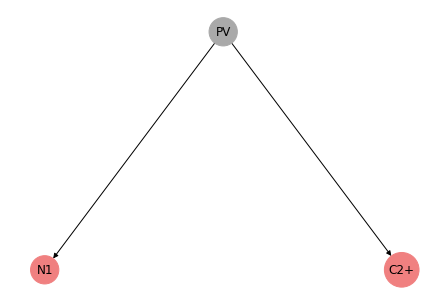

In [6]:
tree = Tree({pv : [n1,c2]})
tree.draw()

#### Check decays step by step:

In [7]:
tree1Step = addOneStepDecays(tree)
print('Step1:')
print(len(tree1Step))
# Count decays:
nN2 = 0
nC1 = 0
nN1 = 0
nOther = 0
for t in tree1Step:
    daughters = [str(n) for n in t.successors(c2)]
    if 'N2'in daughters:
        nN2 +=1
    elif 'C1+' in daughters or 'C1-' in daughters:
        nC1 +=1 
    elif 'N1'in daughters:
        nN1 +=1 
    else:
        nOther +=1 
print('nN2 = %i, nC1 = %i, nN1 = %i, nOther = %i\n' %(nN2,nC1,nN1,nOther))


print('Step2:')
tree2Step = []
for t in tree1Step:
    tree2Step += addOneStepDecays(t)
print(len(tree2Step))
# Count decays:
nN2 = 0
nC1 = 0
nN1 = 0
nOther = 0
for t in tree2Step:
    daughters = [str(n) for n in t.successors(c2)]
    if 'N2'in daughters:
        nN2 +=1
    elif 'C1+' in daughters or 'C1-' in daughters:
        nC1 +=1 
    elif 'N1'in daughters:
        nN1 +=1 
    else:
        nOther +=1 
print('nN2 = %i, nC1 = %i, nN1 = %i, nOther = %i\n' %(nN2,nC1,nN1,nOther))


print('Step3:')
tree3Step = []
for t in tree2Step:
    daughters = [str(n) for n in t.successors(c2)]
#     print(daughters)
    tree3Step += addOneStepDecays(t)
print(len(tree3Step))
# Count decays:
nN2 = 0
nC1 = 0
nN1 = 0
nOther = 0
for t in tree3Step:
    daughters = [str(n) for n in t.successors(c2)]
    if 'N2'in daughters:
        nN2 +=1
    elif 'C1+' in daughters or 'C1-' in daughters:
        nC1 +=1 
    elif 'N1'in daughters:
        nN1 +=1 
    else:
        nOther +=1 
print('nN2 = %i, nC1 = %i, nN1 = %i, nOther = %i' %(nN2,nC1,nN1,nOther))

Step1:
4
nN2 = 1, nC1 = 2, nN1 = 1, nOther = 0

Step2:
30
nN2 = 20, nC1 = 10, nN1 = 0, nOther = 0

Step3:
40
nN2 = 40, nC1 = 0, nN1 = 0, nOther = 0


### Compute full cascade decay

In [8]:
treeList = cascadeDecay(tree)
print('Total= %i (expected = %i)' %(len(treeList),63))
# Count decays:
nN2 = 0
nC1 = 0
nN1 = 0
nOther = 0
for t in treeList:
    daughters = [str(n) for n in t.successors(c2)]
    if 'N2'in daughters:
        nN2 +=1
    elif 'C1+' in daughters or 'C1-' in daughters:
        nC1 +=1 
    elif 'N1'in daughters:
        nN1 +=1 
    else:
        nOther +=1 
print('nN2 = %i, nC1 = %i, nN1 = %i, nOther = %i' %(nN2,nC1,nN1,nOther))
print('nN2 = %i, nC1 = %i, nN1 = %i, nOther = %i (expected)' %(52,10,1,0))

Total= 63 (expected = 63)
nN2 = 52, nC1 = 10, nN1 = 1, nOther = 0
nN2 = 52, nC1 = 10, nN1 = 1, nOther = 0 (expected)


In [9]:
totalXsec = 0*fb
for t in treeList:
    totalXsec += t.getTreeWeight()
print('Total xsec = %s (expected = %s)' %(totalXsec,1*fb))

Total xsec = 1.00E+00 [fb] (expected = 1.00E+00 [fb])


#### Compare with simple count from SLHA file:

In [10]:
totalDecays = 1    
for n in tree.nodes:
    if str(n) == 'PV':
        continue
    totalDecays *= getNdecays(n.particle.pdg)
print(totalDecays)

63


### Second case (2-branches)

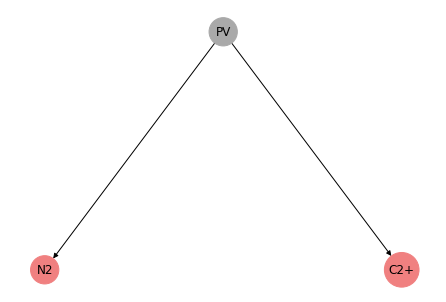

In [11]:
slhafile = '../inputFiles/slha/lightEWinos_simple.slha'
model = Model(BSMparticles=BSMList, SMparticles=SMList)
model.updateParticles(inputFile=slhafile)

pv = ParticleNode(model.getParticlesWith(label='PV')[0],0)
pv.nodeWeight = 1.0*fb
n2 = ParticleNode(model.getParticlesWith(pdg=1000023)[0],1)
c2 = ParticleNode(model.getParticlesWith(pdg=1000037)[0],2)

tree = Tree({pv : [n2,c2]})
tree.draw()

In [12]:
treeList = cascadeDecay(tree)
nN2tot = 6
nC2tot = 3
print(len(treeList),'(expected = %i)' %(nC2tot*nN2tot))
# Count decays:
nN2 = 0
nC1 = 0
nN1 = 0
nOther = 0
xsecDict = {'N2' : 0.0*fb, 'C1' : 0.0*fb, 'N1' : 0.0*fb}
for t in treeList:
    daughters = [str(n) for n in t.successors(c2)]
    if 'N2'in daughters:
        nN2 +=1
        xsecDict['N2'] += t.getTreeWeight()
    elif 'C1+' in daughters or 'C1-' in daughters:
        nC1 +=1 
        xsecDict['C1'] += t.getTreeWeight()
    elif 'N1'in daughters:
        nN1 +=1 
        xsecDict['N1'] += t.getTreeWeight()
    else:
        nOther +=1 

        
print('C2+ decays:')        
print('\t nN2 = %i, nC1 = %i, nN1 = %i, nOther = %i' %(nN2,nC1,nN1,nOther))
print('\t nN2 = %i, nC1 = %i, nN1 = %i, nOther = %i (expected)' %(0*nN2tot,2*nN2tot,nN2tot,0))
print('Xsec:',xsecDict)
      
# Count decays:
nN2 = 0
nC1 = 0
nN1 = 0
nOther = 0
xsecDict = {'N2' : 0.0*fb, 'C1' : 0.0*fb, 'N1' : 0.0*fb}
for t in treeList:
    daughters = [str(n) for n in t.successors(n2)]
    if 'N2'in daughters:
        nN2 +=1
        xsecDict['N2'] += t.getTreeWeight()
    elif 'C1+' in daughters or 'C1-' in daughters:
        nC1 +=1 
        xsecDict['C1'] += t.getTreeWeight()
    elif 'N1'in daughters:
        nN1 +=1 
        xsecDict['N1'] += t.getTreeWeight()
    else:
        nOther +=1 
        
print('\nN2 decays:')        
print('\t nN2 = %i, nC1 = %i, nN1 = %i, nOther = %i' %(nN2,nC1,nN1,nOther))     
print('\t nN2 = %i, nC1 = %i, nN1 = %i, nOther = %i (expected)' %(0*nC2tot,4*nC2tot,2*nC2tot,0))
print('Xsec:',xsecDict)

18 (expected = 18)
C2+ decays:
	 nN2 = 0, nC1 = 12, nN1 = 6, nOther = 0
	 nN2 = 0, nC1 = 12, nN1 = 6, nOther = 0 (expected)
Xsec: {'N2': 0.00E+00 [fb], 'C1': 3.33E-01 [fb], 'N1': 6.67E-01 [fb]}

N2 decays:
	 nN2 = 0, nC1 = 12, nN1 = 6, nOther = 0
	 nN2 = 0, nC1 = 12, nN1 = 6, nOther = 0 (expected)
Xsec: {'N2': 0.00E+00 [fb], 'C1': 8.00E-01 [fb], 'N1': 2.00E-01 [fb]}


In [13]:
totalDecays = 1    
for n in tree.nodes:
    if str(n) == 'PV':
        continue
    totalDecays *= getNdecays(n.particle.pdg)
print(totalDecays)

18


In [14]:
totalXsec = 0*fb
for t in treeList:
    totalXsec += t.getTreeWeight()
print('Total xsec = %s (expected = %s)' %(totalXsec,1*fb))

Total xsec = 1.00E+00 [fb] (expected = 1.00E+00 [fb])


#### With the possibility of stable final states:

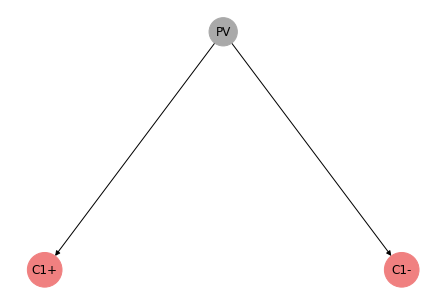

In [15]:
slhafile = '../inputFiles/slha/lightEWinos_simple.slha'
model = Model(BSMparticles=BSMList, SMparticles=SMList)
model.updateParticles(inputFile=slhafile, promptWidth=1e-4*GeV)

pv = ParticleNode(model.getParticlesWith(label='PV')[0],0)
pv.nodeWeight = 1.0*fb
c1p = ParticleNode(model.getParticlesWith(pdg=1000024)[0],1)
c1m = ParticleNode(model.getParticlesWith(pdg=-1000024)[0],2)

tree = Tree({pv : [c1p,c1m]})
tree.draw()

In [16]:
treeList = cascadeDecay(tree)
nExpected = 2*2 + 1*2 + 2*1 +1
print(len(treeList))
print(nExpected,'(expected)')
# for t in treeList:
#     drawTree(t)

9
9 (expected)


### Stress test

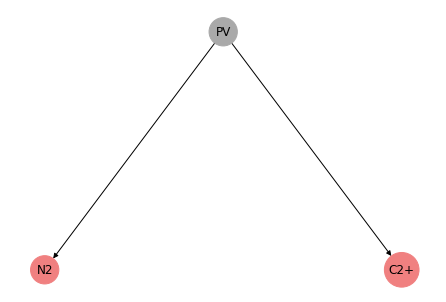

In [17]:
slhafile = '../inputFiles/slha/lightEWinos.slha'
model = Model(BSMparticles=BSMList, SMparticles=SMList)
model.updateParticles(inputFile=slhafile)

pv = ParticleNode(model.getParticlesWith(label='PV')[0],0)
pv.nodeWeight = 3.5*fb
n2 = ParticleNode(model.getParticlesWith(pdg=1000023)[0],1)
c2 = ParticleNode(model.getParticlesWith(pdg=1000037)[0],2)

tree = Tree({pv : [n2,c2]})
tree.draw()

In [18]:
treeList = cascadeDecay(tree)
nN2tot = 52
nC2tot = 63
print(len(treeList),'(expected = %i)' %(nC2tot*nN2tot))

3276 (expected = 3276)


In [19]:
treeList = sorted(treeList, key = lambda t: t.getTreeWeight(), reverse=True)

In [20]:
totalXsec = 0*fb
nCut = 0
cut = 0.07*fb
xsecCut = 0.0*fb
for t in treeList:
    w = t.getTreeWeight()
    totalXsec += w
    if w > cut:
        nCut += 1
        xsecCut += w
print('Total xsec = %s (expected = %s)' %(totalXsec,3.5*fb))

Total xsec = 3.50E+00 [fb] (expected = 3.50E+00 [fb])


In [21]:
treeList = cascadeDecay(tree,sigmacut=cut)
print(len(treeList),'(expected = %i)' %(nCut))

6 (expected = 6)


In [22]:
totalXsec = 0*fb
for t in treeList:
    totalXsec += t.getTreeWeight()
print('Total xsec = %s (expected = %s)' %(totalXsec,xsecCut))

Total xsec = 4.38E-01 [fb] (expected = 4.38E-01 [fb])
